Starting the process...
Starting data download and extraction...
Error in downloading or extracting data. Using fallback file.
Loading data from /content/Rotten_Tomatoes_Movies3.xls...
Data loaded successfully.
Exploring dataset...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  da

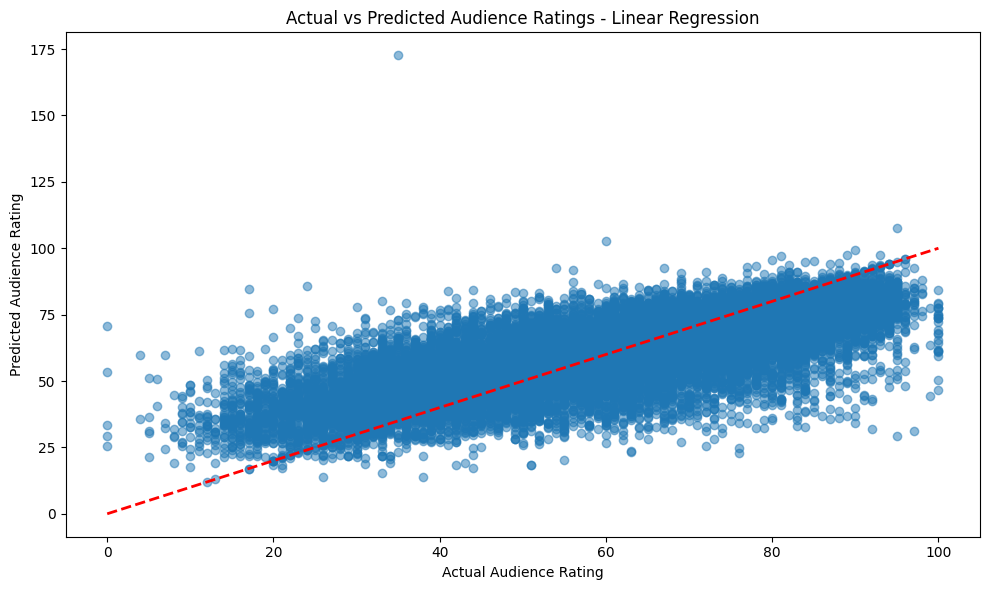

Visualization complete for model: Linear Regression.
Visualizing results for model: Random Forest...


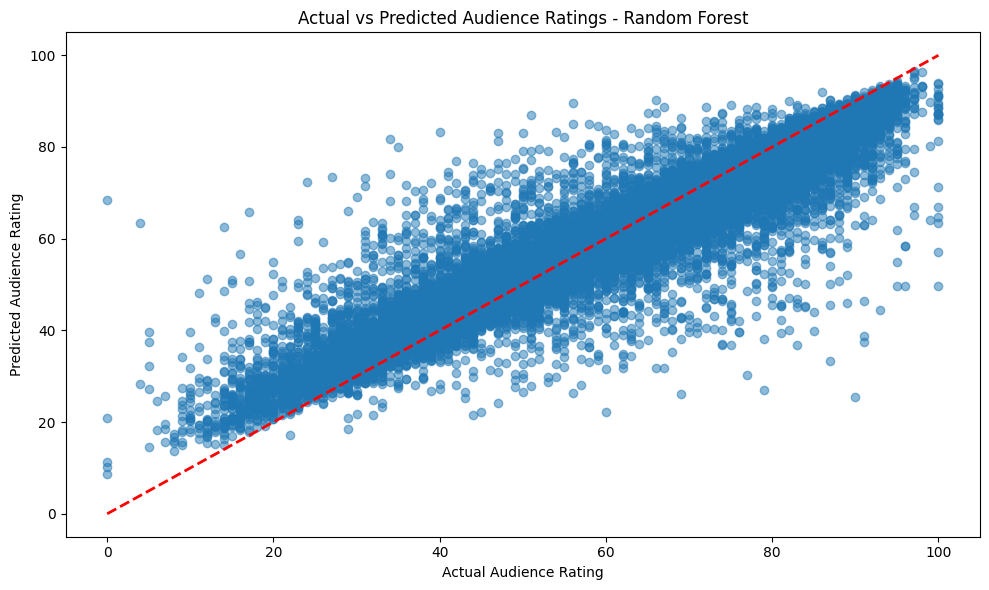

Visualization complete for model: Random Forest.
Visualizing results for model: Gradient Boosting...


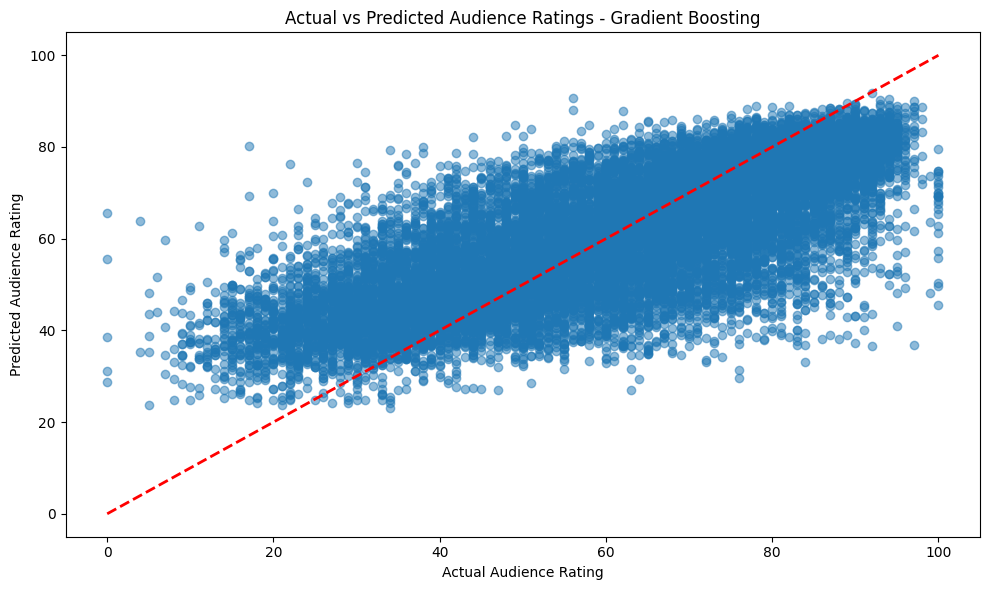

Visualization complete for model: Gradient Boosting.
Comparing model performance...


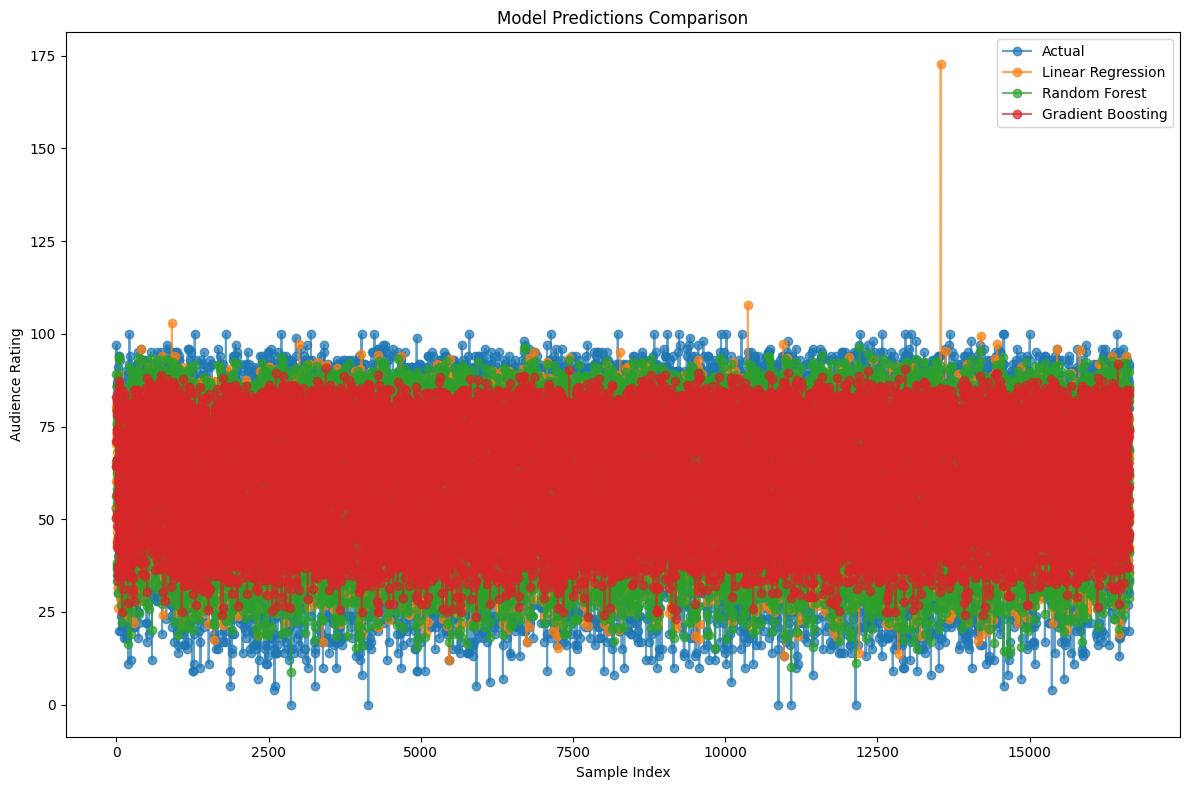

Model performance comparison complete.
Process complete.


In [11]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Constants
ZIP_URL = "https://workdrive.zohoexternal.com/external/544c9e31d9c0a3571cb4010256ba779e0c02dba5f2a0496d15656eb5f119d553"
ZIP_FILE = "data.zip"
EXTRACT_DIR = "./data"
DATA_FILE = os.path.join(EXTRACT_DIR, "Rotten_Tomatoes_Movies3.xls")
FALLBACK_FILE = "/content/Rotten_Tomatoes_Movies3.xls"
TEST_SIZE = 0.2
CV_FOLDS = 5
RANDOM_STATE = 42
N_ESTIMATORS = 100

COLUMN_NAMES = {
    "target": "audience_rating",
    "features": ["rating", "genre", "runtime_in_minutes", "tomatometer_rating", "tomatometer_count"],
    "numeric": ["runtime_in_minutes", "tomatometer_rating", "tomatometer_count"],
    "categorical": ["rating", "genre"]
}

NUM_CORES = multiprocessing.cpu_count()


def download_and_extract_data():
    try:
        print("Starting data download and extraction...")
        if not os.path.exists(EXTRACT_DIR):
            os.makedirs(EXTRACT_DIR)
        response = requests.get(ZIP_URL, stream=True)
        with open(ZIP_FILE, "wb") as file:
            file.write(response.content)
        with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)
        print("Data downloaded and extracted successfully.")
        return DATA_FILE
    except Exception:
        print("Error in downloading or extracting data. Using fallback file.")
        return FALLBACK_FILE


def load_and_explore_data(file_path):
    print(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path)
    print("Data loaded successfully.")
    print("Exploring dataset...")
    df.info()
    df.isnull().sum()
    df.describe()
    print("Data exploration complete.")
    return df


def preprocess_data(df):
    print("Starting data preprocessing...")
    df_clean = df.dropna(subset=[COLUMN_NAMES["target"]])
    X = df_clean[COLUMN_NAMES["features"]]
    y = df_clean[COLUMN_NAMES["target"]]
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, COLUMN_NAMES["numeric"]),
            ('cat', categorical_transformer, COLUMN_NAMES["categorical"])
        ])
    print("Data preprocessing complete.")
    return X, y, preprocessor


def train_single_model(model, model_name, X, y, preprocessor):
    print(f"Training model: {model_name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    cv_scores = cross_val_score(pipeline, X, y, cv=CV_FOLDS, scoring='r2')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Model {model_name} training complete.")
    return {
        'Model Name': model_name,
        'R2 Score': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Cross-Val R2 Mean': cv_scores.mean(),
        'Cross-Val R2 Std': cv_scores.std(),
        'Pipeline': pipeline
    }


def train_and_evaluate_models(X, y, preprocessor):
    print("Starting parallel model training and evaluation...")
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    }
    results = Parallel(n_jobs=NUM_CORES)(
        delayed(train_single_model)(model, name, X, y, preprocessor)
        for name, model in models.items()
    )
    print("Model training and evaluation complete.")
    return {result['Model Name']: result for result in results}


def visualize_results(y_test, y_pred, model_name):
    print(f"Visualizing results for model: {model_name}...")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Actual vs Predicted Audience Ratings - {model_name}')
    plt.xlabel('Actual Audience Rating')
    plt.ylabel('Predicted Audience Rating')
    plt.tight_layout()
    plt.show()
    print(f"Visualization complete for model: {model_name}.")


def compare_model_performance(results, y_test, y_preds):
    print("Comparing model performance...")
    combined_df = pd.DataFrame({'Actual': y_test})
    for model_name, y_pred in y_preds.items():
        combined_df[model_name] = y_pred
    combined_df.plot(
        kind='line', figsize=(12, 8), alpha=0.7, marker='o', title="Model Predictions Comparison"
    )
    plt.xlabel("Sample Index")
    plt.ylabel("Audience Rating")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print("Model performance comparison complete.")


def main():
    print("Starting the process...")
    data_file = download_and_extract_data()
    df = load_and_explore_data(data_file)
    X, y, preprocessor = preprocess_data(df)
    results = train_and_evaluate_models(X, y, preprocessor)
    print("\nModel Performance:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        for metric, value in metrics.items():
            if metric != 'Pipeline':
                print(f"{metric}: {value}")
    y_test, y_preds = {}, {}
    for name, metrics in results.items():
        pipeline = metrics['Pipeline']
        y_preds[name] = pipeline.predict(X)
        visualize_results(y, y_preds[name], name)
    compare_model_performance(results, y, y_preds)
    print("Process complete.")


if __name__ == '__main__':
    main()
